In [ ]:
!pip install biopython # Install the biopython library which contains the SeqIO module.
from Bio import SeqIO
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import accuracy_score
from google.colab import drive
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Open and extract the data from the files (natural and artificial).

In [3]:
def read_FAA(path):
    seq = {}

    # Parse the FASTA file
    with open(path, "r") as file:
        header = None
        sequence_lines = []
        for line in file:
            line = line.strip()  # Remove whitespace
            if line.startswith(">"):  # Header line
                if header:
                    # Add the previous sequence to the dictionary
                    seq_num, func_label = header.split(" ", 1)
                    seq[seq_num] = {
                        "Functional_Label": func_label,
                        "Sequence": "".join(sequence_lines)
                    }
                header = line[1:]  # Remove ">" to get the header content
                sequence_lines = []  # Reset sequence storage
            else:
                sequence_lines.append(line)  # Collect sequence lines
        # Add the last sequence
        if header:
            seq_num, func_label = header.split(" ", 1)
            seq[seq_num] = {
                "Functional_Label": func_label,
                "Sequence": "".join(sequence_lines)
            }
    return seq

artificial = read_FAA('/content/drive/MyDrive/CS_Project/MSA_art.faa')
natural =read_FAA('/content/drive/MyDrive/CS_Project/MSA_nat_with_annotation.faa')

# Task 1

Translates a letter in a 20 dimensional vector.

In [4]:
def letter2vector(a):
    switcher = {
        '-':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'A':np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'C':np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'D':np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'E':np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'F':np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'G':np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'H':np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'I':np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),
        'K':np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]),
        'L':np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
        'M':np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]),
        'N':np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]),
        'P':np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]),
        'Q':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]),
        'R':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]),
        'S':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]),
        'T':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]),
        'V':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]),
        'W':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]),
        'Y':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]),
    }
    #return switcher.get(a, "nothing")
    return switcher.get(a,0)

Translate each protein sequence in string form to vector form.

In [5]:
def encode_sequence(sequence):
    return np.concatenate([letter2vector(letter) for letter in sequence])


# Dictionary
encoded_natural = {key: encode_sequence(value["Sequence"]) for key, value in natural.items()}
encoded_artificial = {key: encode_sequence(value["Sequence"]) for key, value in artificial.items()}


# Separate True and False sequences in different lists
def True_False(data, encoded):
  True_sequence = []
  False_sequence = []
  for key, values in data.items():
    if values["Functional_Label"] == 'functional_true':
        True_sequence.append(encoded[key])
    else:
        False_sequence.append(encoded[key])
  return True_sequence, False_sequence


True_natural, False_natural = True_False(natural, encoded_natural)
True_artificial, False_artificial = True_False(artificial, encoded_artificial)

#Task 2

*Use PCA of the natural data in one-hot encoding, to determine the first few principle components (PCs) of the
dataset. Project sequences onto PCs and represent graphically the dimensionally reduced data. What do you observe?
Color sequences according to their functionality. Are functional and non-functional sequences well sperarated in
PCA space? Project also the generated sequences onto the PCs determined from the natural data. Do they occupy
a similar region in (dimensionally reduced) sequence space?*


I would say that we shouldn't rescale the data since a difference in the variance of two different elements (of the 2920 dimensional vector) should be informative (for example, for two succesive elements associated to the same amino acid position, it could mean that in a given position of the sequence one amino acid is more often present than an other one).

The following code allows us to plot 6 figures to represent the data points in 2 dimension, using the four principal components. This is done for different datasets.

In [6]:
def perform_pca_analysis(i, array1, array2, nb_component, *, array3=[]):
    """
    Perform PCA analysis on the combination of two numpy arrays and create comparison plots.

    Parameters:
    array1 (np.ndarray): First dataset array of shape (n_samples1, n_features)
    array2 (np.ndarray): Second dataset array of shape (n_samples2, n_features)

    Returns:
    tuple: (pca, transformed1, transformed2) - PCA object and transformed data for both datasets
    """
    # Combine arrays
    combined_array = np.vstack((array1, array2))
    transformed3 = []


    # Perform PCA on combined data with 4 components
    pca = [PCA(n_components=nb_component) for i in range(10)]
    combined_transformed = pca[i].fit_transform(combined_array)
    if len(array3) != 0:
      transformed3 = pca[i].transform(array3)


    # Split back into original datasets
    n_samples1 = array1.shape[0]
    transformed1 = combined_transformed[:n_samples1]
    transformed2 = combined_transformed[n_samples1:]

    return pca[i], transformed1, transformed2, transformed3

def plot_pca_comparisons(transformed1, transformed2, dataset1_name="Dataset 1", dataset2_name="Dataset 2", opacity=[]):
    """
    Create six plots comparing different principal components between datasets.

    Parameters:
    transformed1 (np.ndarray): Transformed data from first dataset
    transformed2 (np.ndarray): Transformed data from second dataset
    dataset1_name (str): Name of first dataset
    dataset2_name (str): Name of second dataset
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot PC1 vs PC2
    axes[0,0].scatter(transformed1[:, 0], transformed1[:, 1], alpha=opacity[0][0], label=dataset1_name, color="r", marker="*")
    axes[0,0].scatter(transformed2[:, 0], transformed2[:, 1], alpha=opacity[0][1], label=dataset2_name, marker="*")
    axes[0,0].set_xlabel('First Principal Component')
    axes[0,0].set_ylabel('Second Principal Component')
    axes[0,0].set_title('PC1 vs PC2')
    axes[0,0].legend()

    # Plot PC2 vs PC3
    axes[0,1].scatter(transformed1[:, 1], transformed1[:, 2], alpha=opacity[1][0], label=dataset1_name, color="r", marker="*")
    axes[0,1].scatter(transformed2[:, 1], transformed2[:, 2], alpha=opacity[1][1], label=dataset2_name, marker="*")
    axes[0,1].set_xlabel('Second Principal Component')
    axes[0,1].set_ylabel('Third Principal Component')
    axes[0,1].set_title('PC2 vs PC3')
    axes[0,1].legend()

    # Plot PC1 vs PC3
    axes[0,2].scatter(transformed1[:, 0], transformed1[:, 2], alpha=opacity[2][0], label=dataset1_name, color="r", marker="*")
    axes[0,2].scatter(transformed2[:, 0], transformed2[:, 2], alpha=opacity[2][1], label=dataset2_name, marker="*")
    axes[0,2].set_xlabel('First Principal Component')
    axes[0,2].set_ylabel('Third Principal Component')
    axes[0,2].set_title('PC1 vs PC3')
    axes[0,2].legend()

    # Plot PC1 vs PC4
    axes[1,0].scatter(transformed1[:, 0], transformed1[:, 3], alpha=opacity[3][0], label=dataset1_name, color="r", marker="*")
    axes[1,0].scatter(transformed2[:, 0], transformed2[:, 3], alpha=opacity[3][1], label=dataset2_name, marker="*")
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Fourth Principal Component')
    axes[1,0].set_title('PC1 vs PC4')
    axes[1,0].legend()

    # Plot PC2 vs PC4
    axes[1,2].scatter(transformed1[:, 1], transformed1[:, 3], alpha=opacity[4][0], label=dataset1_name, color="r", marker="*")
    axes[1,2].scatter(transformed2[:, 1], transformed2[:, 3], alpha=opacity[4][1], label=dataset2_name, marker="*")
    axes[1,2].set_xlabel('Second Principal Component')
    axes[1,2].set_ylabel('Fourth Principal Component')
    axes[1,2].set_title('PC2 vs PC4')
    axes[1,2].legend()

    # Plot PC3 vs PC4
    axes[1,1].scatter(transformed1[:, 2], transformed1[:, 3], alpha=opacity[5][0], label=dataset1_name, color="r", marker="*")
    axes[1,1].scatter(transformed2[:, 2], transformed2[:, 3], alpha=opacity[5][1], label=dataset2_name, marker="*")
    axes[1,1].set_xlabel('Third Principal Component')
    axes[1,1].set_ylabel('Fourth Principal Component')
    axes[1,1].set_title('PC3 vs PC4')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca, nb):
    """
    Plot explained variance ratios for the combined PCA.

    Parameters:
    pca (PCA): PCA object from combined dataset analysis
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    components = range(1, len(pca.explained_variance_ratio_)+1)  # Updated to show 4 components
    axes[0].plot(components, pca.explained_variance_ratio_, 'o-')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[1].plot(components, cumulative_explained_variance, 'x-')
    axes[1].set_ylabel('Explained Variance Ratio (Cumulative)')

    for i in range(2):
      axes[i].set_xlabel('Principal Components')

    plt.tight_layout()
    plt.show()

    return cumulative_explained_variance

In [7]:
print(f"Ratio of True data points = {len(True_natural)/(len(False_natural)+len(True_natural))}")

Ratio of True data points = 0.3743362831858407


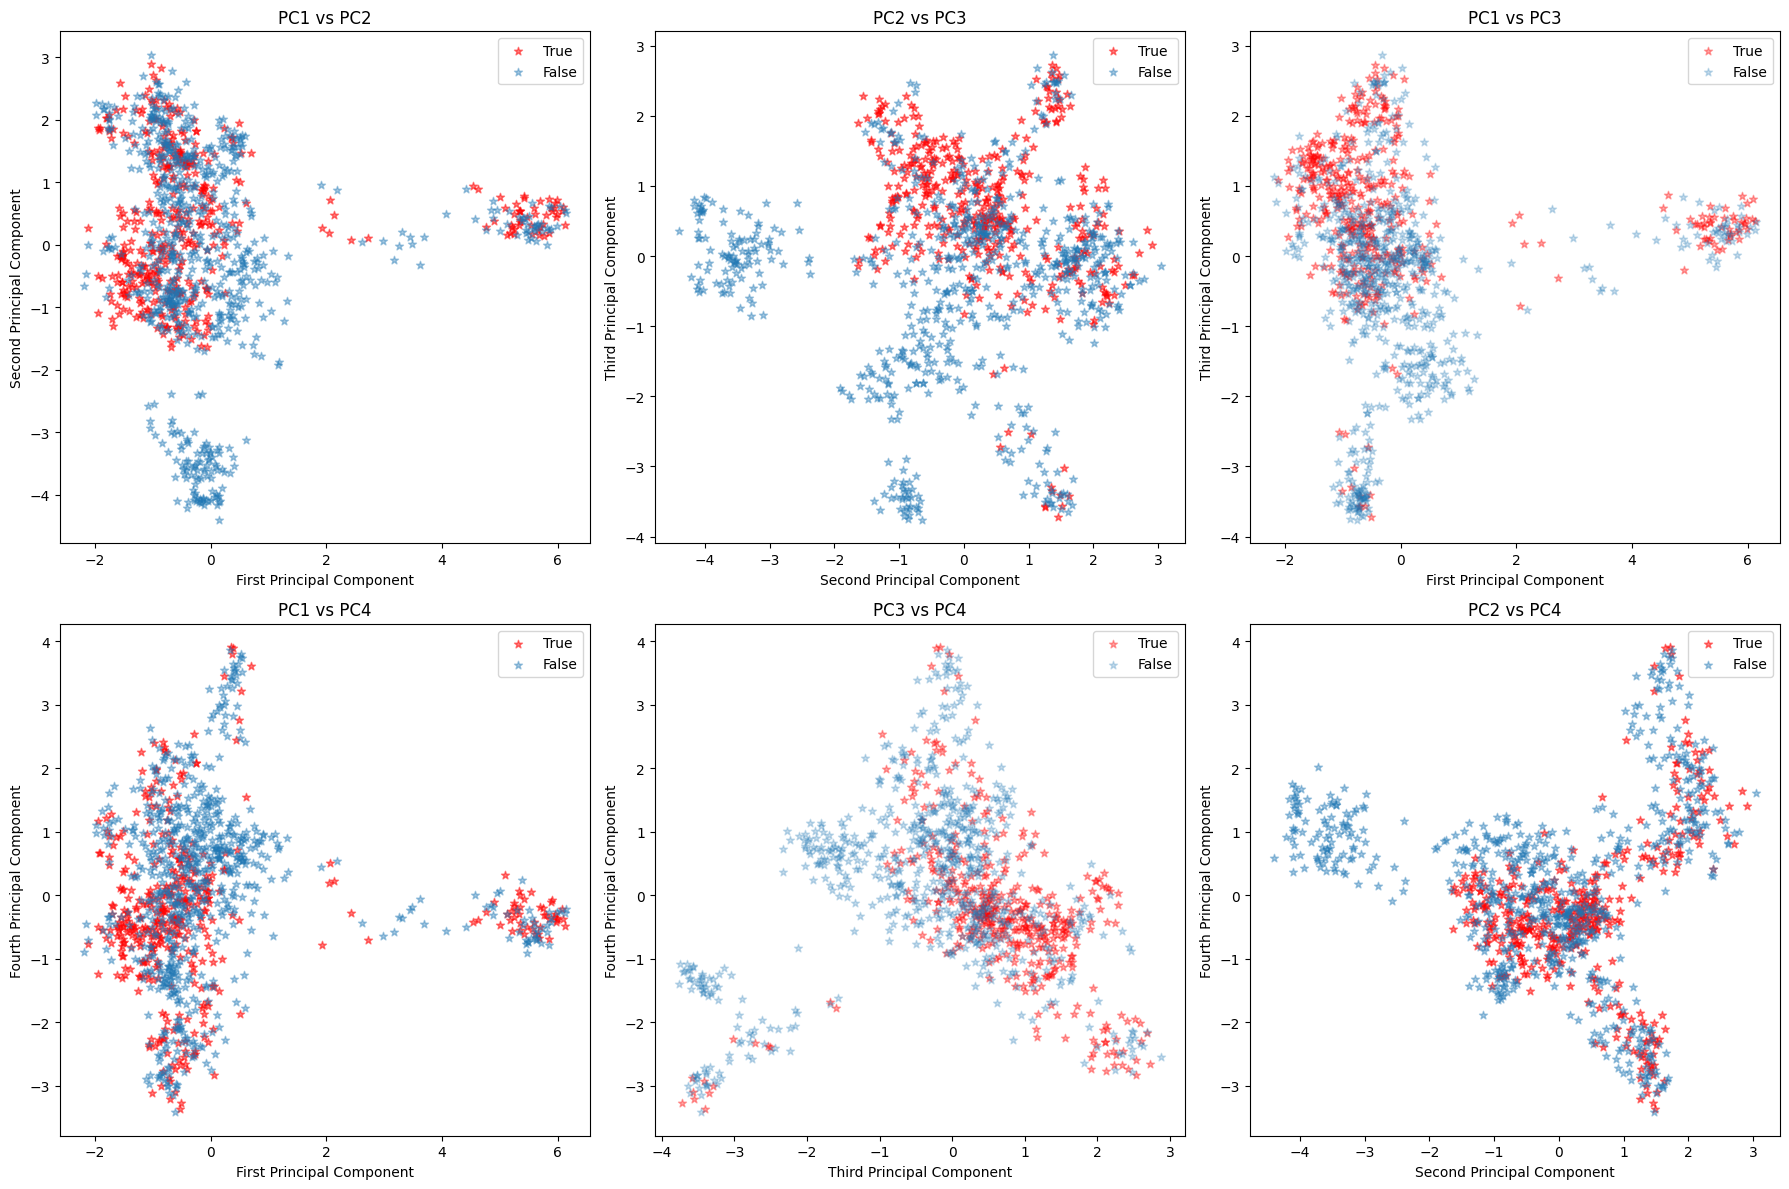

In [8]:
opacity = [(0.5, 0.4), (0.5, 0.4), (0.35, 0.25), (0.5, 0.4), (0.5, 0.4), (0.35, 0.25)]
pca_nat, transformed1_nat, transformed2_nat, transformed3 = perform_pca_analysis(0, np.array(True_natural), np.array(False_natural), 4)
plot_pca_comparisons(transformed1_nat, transformed2_nat, "True", "False", opacity)

First of all, we can see that the data contains some dense regions (in data points) separated by sparse/empty regions. It can be seen in PC1 vs PC3 for both data points of protein's functioning in an experimental screen (labelled "True") and protein's that don't
function in experimental screen (labelled "False"). Thus we can infer that the data can be separated into clusters.

When we compare True and False data points we can see that True datapoints occupy a smaller region of the overall space compared to False datapoints. Moreover the regions occupied by True datapoints seems to be also ocupied by False datapoints, but False datapoints are present in regions of space inocupied by True datapoints this can be seen clearly in PC2 vs PC3. Thus from the first four principal components True and False datapoints are not well separeted since they both occupy some identical regions (in all the 6 2D projections).

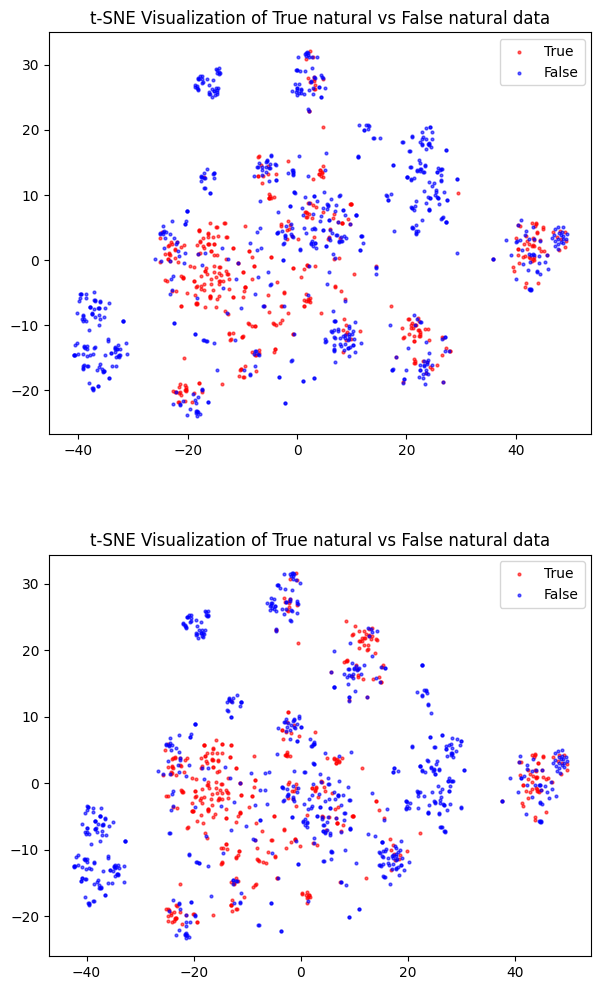

In [9]:
fig = plt.figure(figsize=(7, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in [1,2]:
  plt.subplot(2, 1, i)
  # Initialize t-SNE to reduce the dimensionality to 2 components with a specified perplexity
  tsne = TSNE(n_components=2, perplexity=60)

  # Apply t-SNE to the data
  X_embedded = tsne.fit_transform(np.vstack((np.array(True_natural), np.array(False_natural))))

  # Get the number of points in each category
  n_true = len(True_natural)

  # Create a scatter plot with different colors for each category
  plt.scatter(X_embedded[:n_true, 0], X_embedded[:n_true, 1],
            c='red', label='True', s=4, alpha=0.6)
  plt.scatter(X_embedded[n_true:, 0], X_embedded[n_true:, 1],
            c='blue', label='False', s=4, alpha=0.6)

  # Add legend and title
  plt.legend()
  plt.title(f't-SNE Visualization of True natural vs False natural data')

  # Show the plot
plt.show()

T-SNE is supposed to preserve the order of distances. But as we can see in the above images around x=y=20 the results we get are different from a T-SNE projection to the other.

The above T-SNE visualisation seems to confirm that the data can be separated into clusters and that True and False datapoints cannot be well separated (, even though in some regions they seems to be well separated, because of the regions where they seems to overlap).

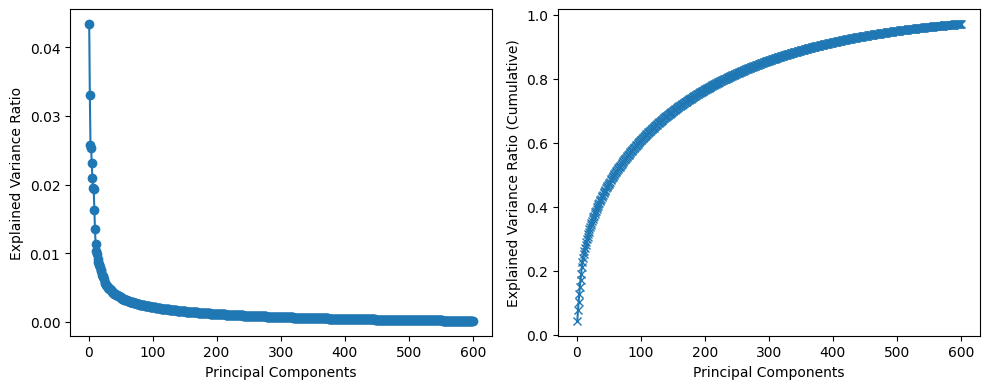

In [10]:
nb_comp = 600
pca, transformed1, transformed2, _ = perform_pca_analysis(2, np.array(True_natural), np.array(False_natural), nb_comp)
cumulative_var = plot_explained_variance(pca, nb_comp)


In [11]:
print(f"Explained variance by 600 components {int(cumulative_var[-1]*100)}%")

Explained variance by 600 components 97%


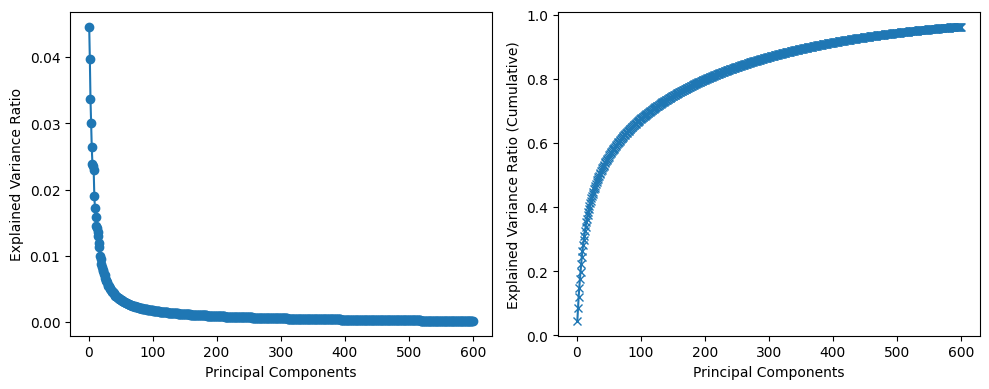

array([0.04460872, 0.08427748, 0.11793048, 0.14791223, 0.17428109,
       0.19821185, 0.22169648, 0.24462079, 0.26364653, 0.28079385,
       0.29665506, 0.31116726, 0.32542254, 0.33903424, 0.35200664,
       0.36388163, 0.37524341, 0.38516566, 0.39472899, 0.40342397,
       0.41175147, 0.41956933, 0.42731468, 0.43460694, 0.44165969,
       0.44833647, 0.45473467, 0.46090087, 0.46695246, 0.47256907,
       0.4780395 , 0.48345927, 0.48862709, 0.49353792, 0.49834639,
       0.50309877, 0.50763905, 0.51210452, 0.51644069, 0.52061034,
       0.52461702, 0.52856976, 0.53244294, 0.53626918, 0.54005366,
       0.54367647, 0.54727593, 0.5507386 , 0.5541934 , 0.5575855 ,
       0.56091623, 0.56421833, 0.56746323, 0.57057055, 0.57366383,
       0.57668089, 0.57965115, 0.58254392, 0.58539087, 0.5882182 ,
       0.59099372, 0.59366941, 0.59631262, 0.59891857, 0.60150743,
       0.60403917, 0.60655392, 0.60903349, 0.61150581, 0.61391924,
       0.61630218, 0.61866164, 0.62099328, 0.62329108, 0.62554

In [12]:
nb_comp = 600
pca, transformed1, transformed2, _ = perform_pca_analysis(3, np.vstack((np.array(True_natural), np.array(False_natural))), np.vstack((np.array(True_artificial), np.array(False_artificial))), nb_comp)
plot_explained_variance(pca, nb_comp)

In [13]:
print(f"Ratio of natural data points = {len(np.vstack((np.array(True_natural),np.array(False_natural))))/ (len(np.vstack((np.array(True_artificial),np.array(False_artificial))))+len(np.vstack((np.array(True_natural),np.array(False_natural)))))}")

Ratio of natural data points = 0.5297702766057196


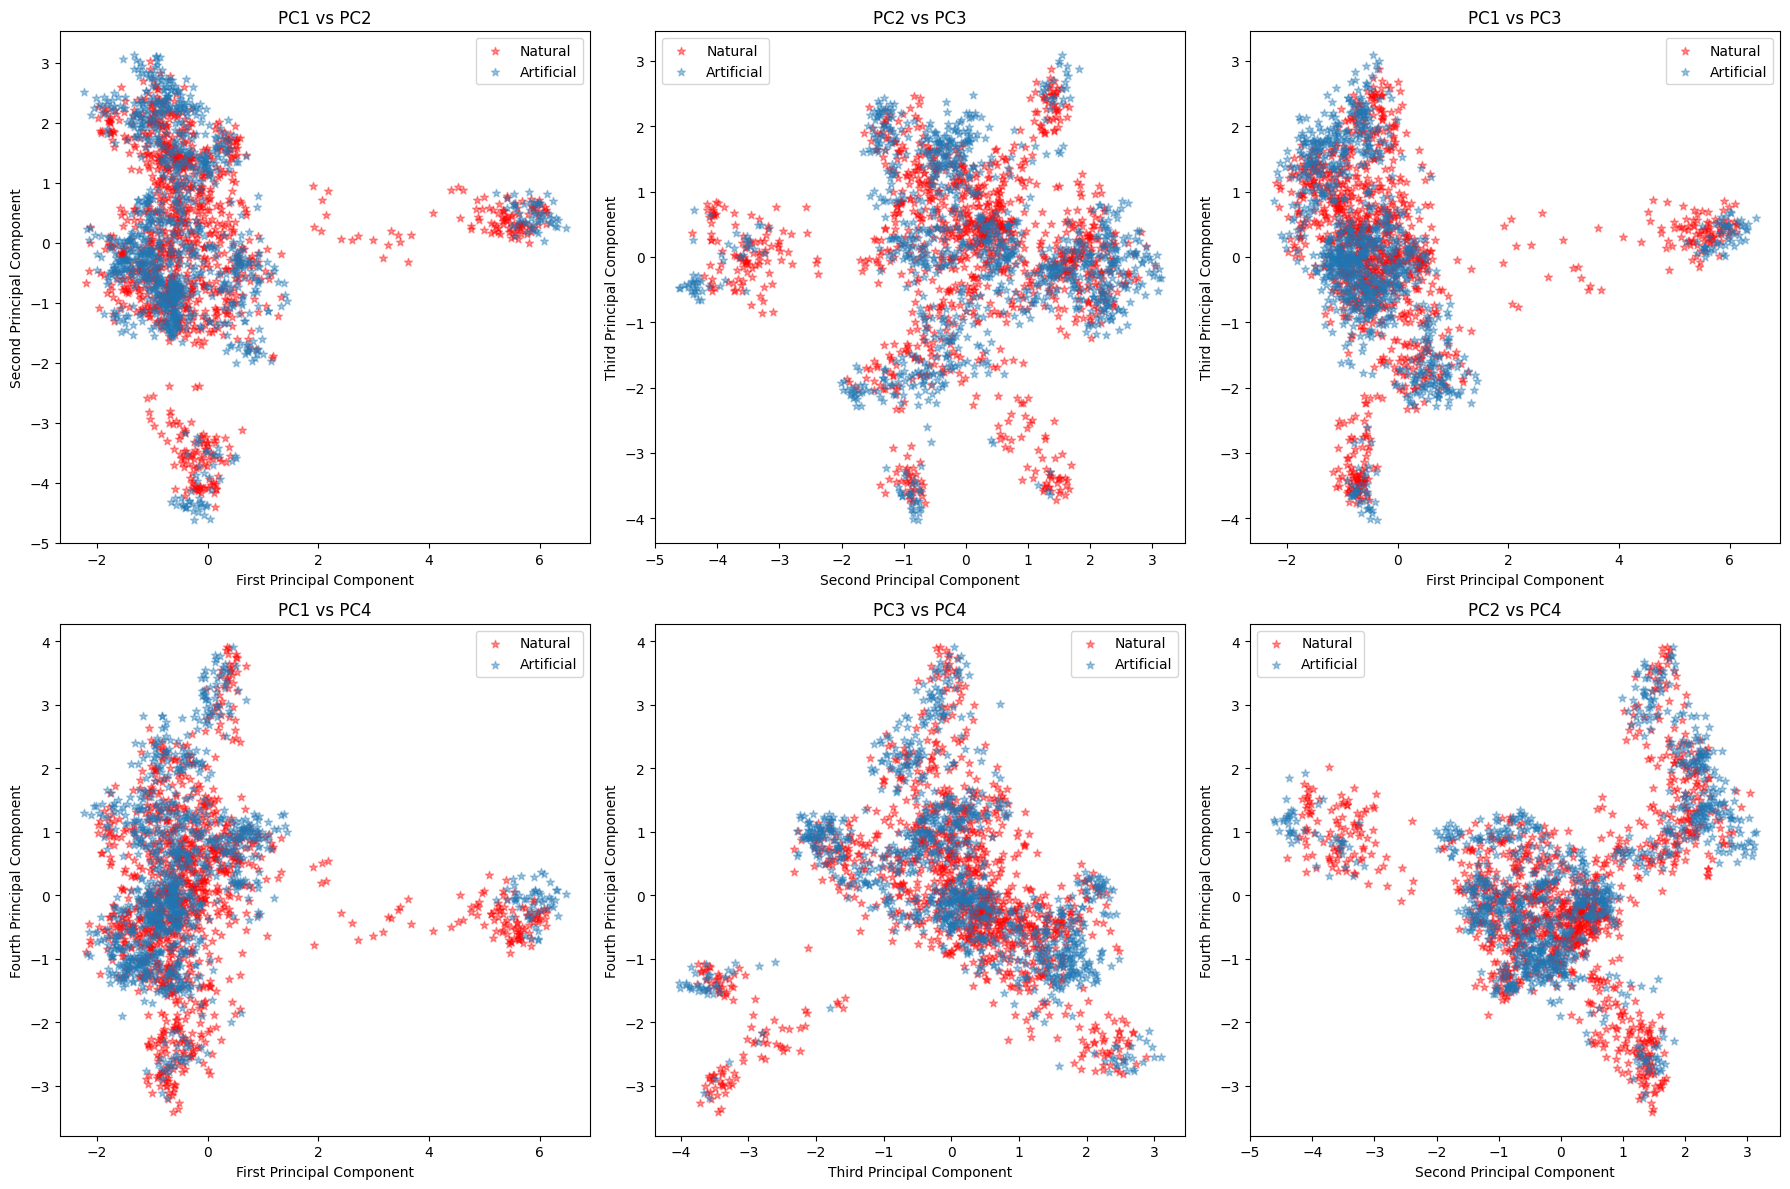

In [14]:
opacity = [(0.4, 0.4) for i in range(6)]
pca, transformed1, transformed2, transformed3 = perform_pca_analysis(1, np.array(True_natural), np.array(False_natural), 4, array3=np.vstack((np.array(True_artificial), np.array(False_artificial))))
plot_pca_comparisons(np.vstack((transformed1, transformed2)), transformed3, "Natural", "Artificial", opacity)

From the four first principal components both natural and artificial datapoints seems to be occupying similar regions of space. But it seems like artificial data points are very dense in some regions and then very sparse or absent of some other regions. Whereas the natural data points seems to occupy a broader region of space. (For instance the artificial data points are not present in the region between 2 and 4 of the first principal component when the Natural ones are).

# Task 3

*Use a clustering algorithm of your choice (k-means, hierarchical...) to cluster the natural sequences, try different
cluster numbers. Represent clusters graphically using the PCA of Task 2. Discuss your observations. Are functional
and nonfunctional sequences separated into distinct clusters?
Unify natural and artificial sequences into one large dataset, and apply again the clustering algorithm. Are the two
datasets separated by this procedure, or are clusters mixed in natural and artificial sequences?*

Since the shape of the spacial arangement of the points present in our dataset seems to be best captured by the third, fourth and fifth line (of the image bellow, coming from the third notebook on clustering), at least from the four principal components, and since from the image bellow it seems like the best algorithm to do clustering in the third, fourth and fifth data configuration (in space) is the Gaussian mixture model, we will use this algorithm.

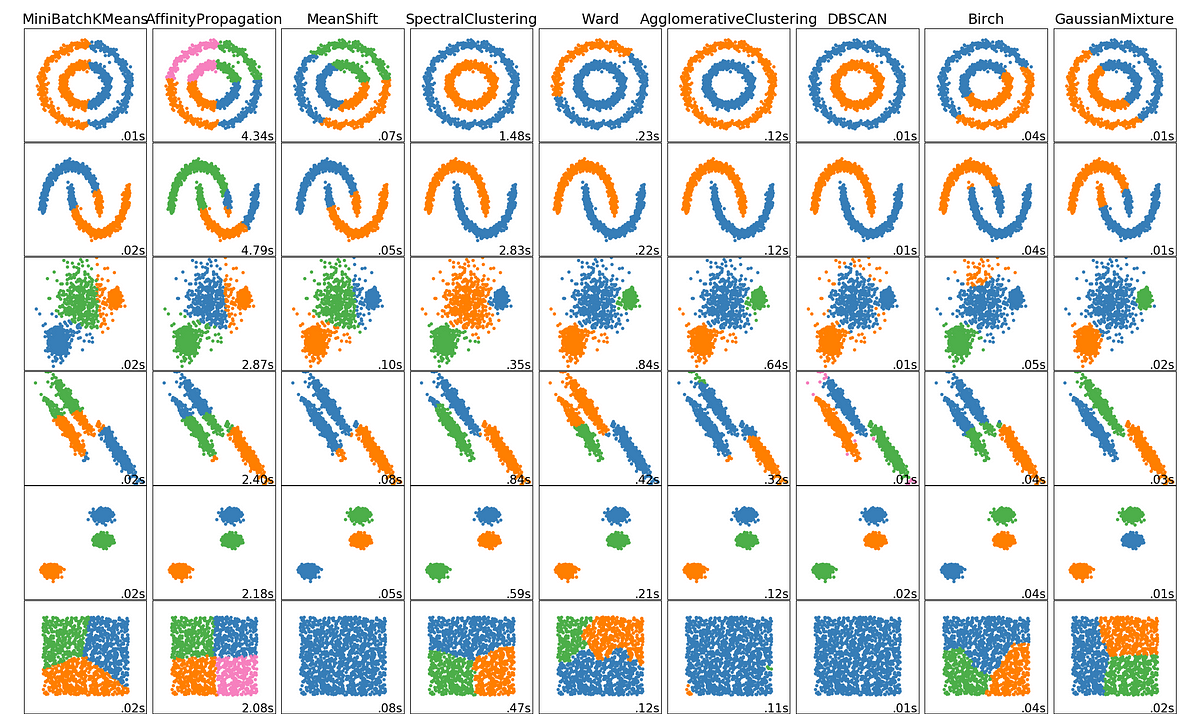

In [15]:
pca_natural, transformed1, transformed2, transformed3 = perform_pca_analysis(4, np.array(True_natural), np.array(False_natural), 600)
opt_cluster_data = np.vstack((transformed1, transformed2))

In [16]:
def find_nb_cluster(data_original, max_nb_cluster):
  # Define a range of values for the number of Gaussian components (n_estimators)
  n_estimators = np.arange(1, max_nb_cluster)

  # Create a list of Gaussian Mixture Models (GMM) for each number of components
  clfs = [GMM(n, max_iter=1500, random_state=30).fit(data_original) for n in n_estimators]  # Fit models with up to 24 components

  # Calculate the Bayesian Information Criterion (BIC) for each model
  bics = [clf.bic(data_original) for clf in clfs]

  # Calculate the Akaike Information Criterion (AIC) for each model
  aics = [clf.aic(data_original) for clf in clfs]

  # Plot BIC and AIC values against the number of components
  plt.plot(n_estimators, bics, label='BIC', color="r")  # Plot BIC values
  plt.plot(n_estimators, aics, label='AIC', color="b")  # Plot AIC values
  plt.legend()  # Show legend

  return clfs

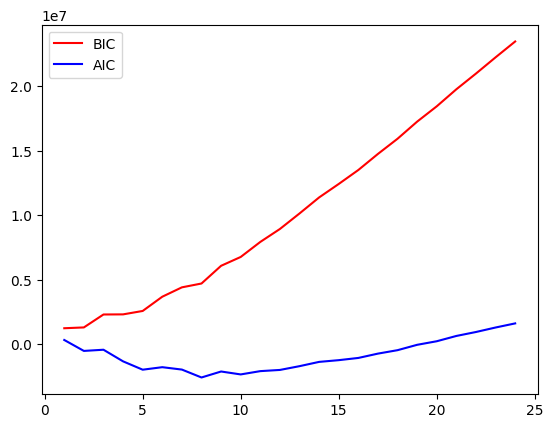

In [17]:
GMMs = find_nb_cluster(opt_cluster_data, 25)

The results from the BIC Criterion seem to suggest that we should use the least amount of component possible. Thus, we will not use this criterium since this is not what we expect from the first few principal components of the data.

In [18]:
def find_nb_cluster_2(clfs, data_original):
  # Calculate the Akaike Information Criterion (AIC) for each model
  aics = [clf.aic(data_original) for clf in clfs]
  log_likelihoods = [clf.score(data_original) for clf in clfs]

  # AIC values against the number of components
  plt.plot([i for i in range(1, len(clfs) + 1)], aics, label='AIC', color="b")  # Plot AIC values
  plt.grid()
  plt.show()

  plt.plot([i for i in range(1, len(clfs) + 1)], log_likelihoods, label='Log Likelihood', color="g")
  plt.grid()
  plt.show()

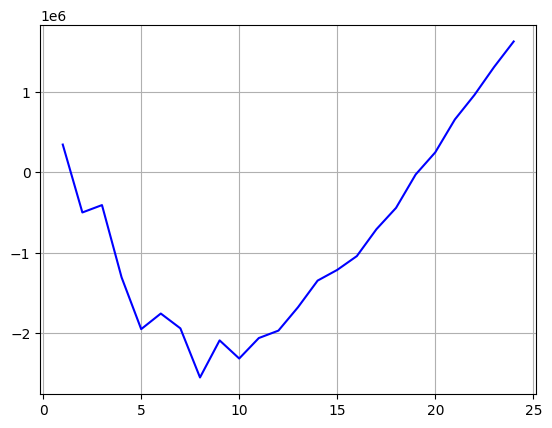

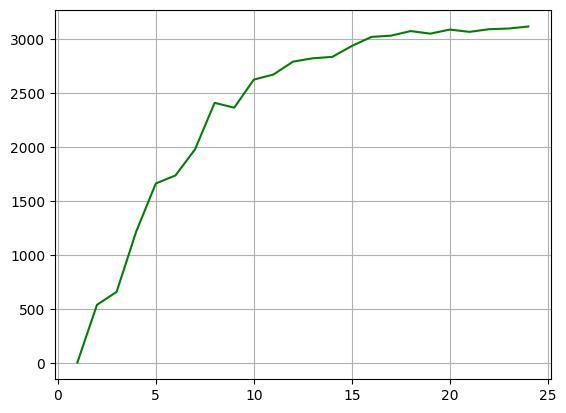

In [19]:
find_nb_cluster_2(GMMs, opt_cluster_data)

From the AIC criterium the optimal number of cluster seems to be 8. Whereas for the log likelihood 16 seems to be the correct number of component (after this value the log likelihood stays aproximately flat). Thus we will take the average of those two values, so 12 components.

The code above allows us to decide the number of clusters we want to use using the AIC and BIC criterions.

In [20]:
def gmm_clustering_pca_vis(gmm_result, data_original, cluster_nbs):
    """
    Perform Gaussian Mixture Model clustering in original space and visualize results using pre-computed PCA.

    Parameters:
    -----------
    data_original : array-like
        Original data matrix for clustering
    data_pca : array-like
        Pre-computed PCA data matrix for visualization
    n_clusters : int
        Number of clusters for GMM
    random_state : int, optional (default=42)
        Random state for reproducibility

    Returns:
    --------
    dict containing:
        'gmm_model': fitted GMM model
        'cluster_labels': cluster assignments
        'cluster_probabilities': probability of cluster membership
    """

    # Create figure with 2 subplots
    fig = plt.figure(figsize=(15, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Use a color palette
    colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948',
              '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC', '#D37295', '#A0CBE8']
    colors = colors[:cluster_nbs[-1]]

    # Adjust the subplots setup to 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Define the combinations for the principal components to plot
    pc_combinations = [(0, 1), (1, 2), (0, 3), (2, 3)]

    plot_idx = 0
    for l in cluster_nbs:  # Iterate through cluster numbers
        cluster_labels = gmm_result[l - 1].predict(data_original)

        # Iterate through principal component combinations
        for i in range(len(pc_combinations)):
            row = i // 2  # Determine subplot row index
            col = i % 2  # Determine subplot column index

            # Get the current subplot
            ax = axes[row, col]

            # Plot points for each cluster
            for k in range(cluster_nbs[-1]):
                mask = cluster_labels == k
                ax.scatter(data_original[mask, pc_combinations[i][0]],
                           data_original[mask, pc_combinations[i][1]],
                           c=[colors[k]], alpha=0.7, label=str(k + 1))

            # Set subplot labels and title
            ax.set_xlabel(f'PC{pc_combinations[i][0] + 1}')
            ax.set_ylabel(f'PC{pc_combinations[i][1] + 1}')
            ax.set_title(str(l) + " cluster")

            # Show legend only on the first subplot
            if i == 0:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



    plt.tight_layout()
    plt.show()

    return



def visualize_existing_clusters_tsne(gmm_results, data_original, cluster_nbs, perplexity=30):
    """
    Visualize existing GMM clustering results using t-SNE.

    Parameters:
    -----------
    gmm_results : dict
        Results from the previous GMM clustering containing:
        - 'cluster_labels': cluster assignments
        - 'cluster_probabilities': probability of cluster membership
        - 'gmm_model': fitted GMM model
    data_original : array-like
        Original data matrix used for clustering
    perplexity : float, optional (default=30)
        Perplexity parameter for t-SNE
    random_state : int, optional (default=42)
        Random state for reproducibility
    """
    # Use the same color palette as in PCA visualization
    colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948',
          '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC', '#D37295', '#A0CBE8']
    colors = colors[:cluster_nbs[-1]]

    # Apply t-SNE
    tsne = TSNE(n_components=2,
                perplexity=perplexity)
    data_tsne = tsne.fit_transform(data_original)

    plot_idx = 1

    # Create figure with 2 subplots
    fig = plt.figure(figsize=(14, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Plot points for each cluster with size based on probability
    for l in cluster_nbs:
      plt.subplot(len(cluster_nbs)//2 + 1, 2, plot_idx)
      # Extract clustering information
      cluster_labels = gmm_results[l-1].predict(data_original)
      cluster_probs = gmm_results[l-1].predict_proba(data_original)

      for i in range(cluster_nbs[-1]):
          mask = cluster_labels == i
          plt.scatter(data_tsne[mask, 0], data_tsne[mask, 1],
                    c=[colors[i]],
                    alpha=0.4,
                    s=10)
      plot_idx += 1

    plt.title('GMM Clustering Results Visualized with t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()

    """# Add information box
    info_text = f'Number of clusters: {n_clusters}\n'
    info_text += f'Original space dimension: {data_original.shape[1]}\n'
    info_text += f't-SNE perplexity: {perplexity}'
    plt.text(0.02, 0.98, info_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')"""

    plt.tight_layout()
    plt.show()

    return data_tsne


The following clustering is done on the Natural data set. (It takes 3 minutes)

<Figure size 1500x600 with 0 Axes>

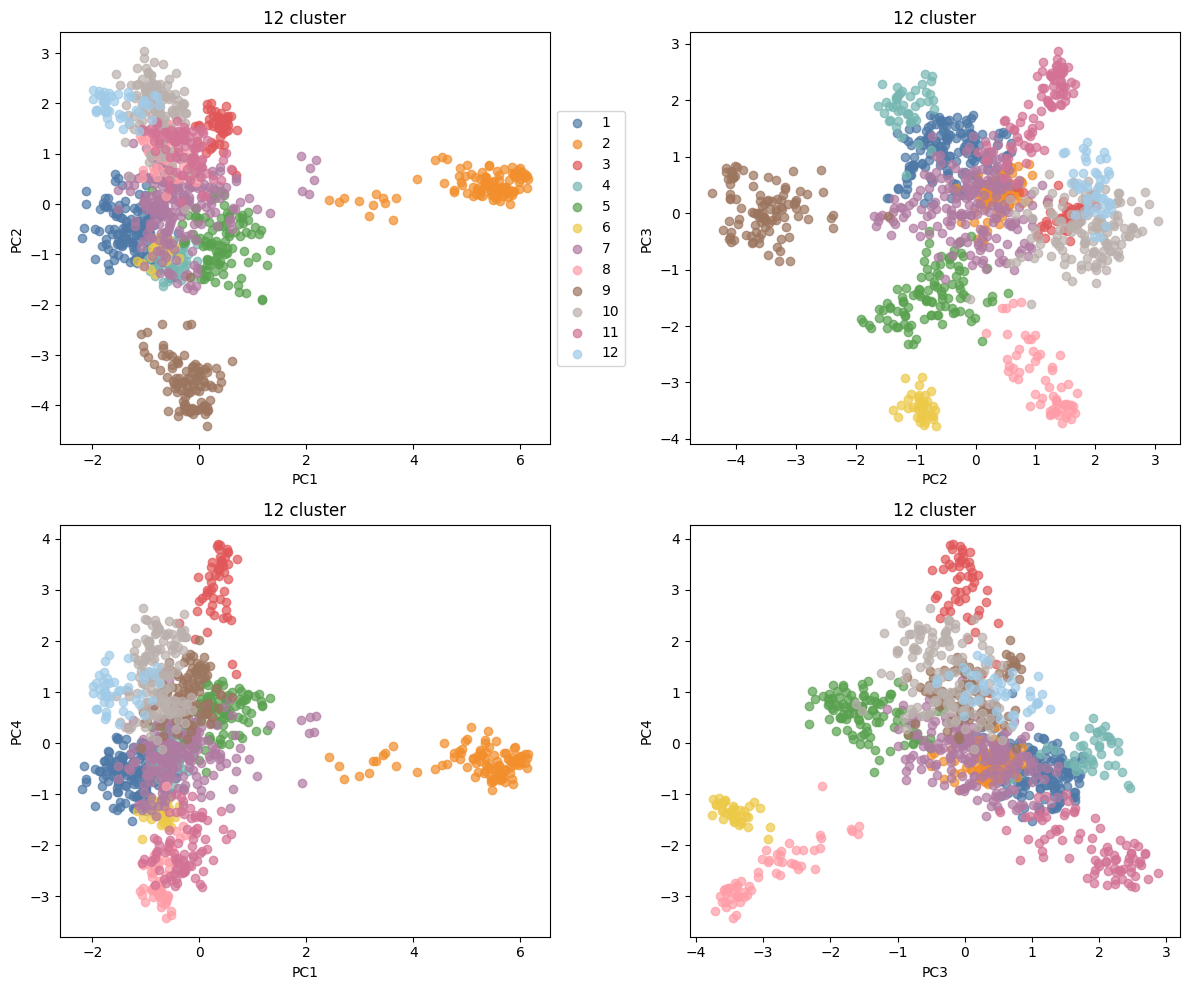

In [21]:
gmm_clustering_pca_vis(GMMs, opt_cluster_data, [12])

From PCA of task two most clusters are overlapping with each other (the ones that can be distinguished are : color 2, 6, 8, 9) . It is thus difficult to evaluate the choise of the number of clusters from the projection of the data in the four first principal components.

<ipython-input-20-580735c3d2fe>:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


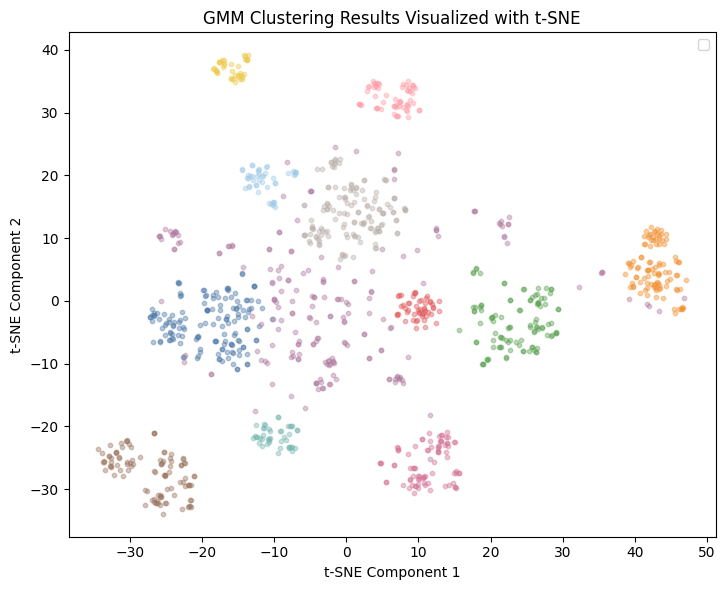

array([[-10.86891 , -21.996277],
       [-10.700094, -22.035473],
       [-10.655615, -21.896639],
       ...,
       [-13.763803,  38.509106],
       [-13.815209,  38.302193],
       [-13.737024,  38.359085]], dtype=float32)

In [22]:
visualize_existing_clusters_tsne(GMMs, opt_cluster_data, [12], perplexity=50)

When we look at the result of T-SNE though it looks like clusters are well separated except for the color 7 (darkest purle) wich covers a very vast area of T-SNE space (with low density of points).

In [23]:
print(transformed1.shape[0]+transformed2.shape[0])

1130


In [24]:
opt_cluster_label = np.array([1 for i in range(len(transformed1))] + [0 for i in range(len(transformed2))])


In [25]:
def evaluate_cluster_purity(gmm, data, functional_labels):
    cluster_labels = gmm.predict(data)

    # Get the number of clusters
    n_clusters = gmm.n_components

    # Evaluate each cluster
    cluster_stats = []
    for i in range(n_clusters):
        mask = cluster_labels == i
        cluster_size = np.sum(mask)
        if cluster_size > 0:
            func_ratio = np.sum(functional_labels[mask]) / cluster_size
            cluster_stats.append({
                'cluster': i,
                'size': cluster_size,
                'functional_ratio': func_ratio,
                'is_primarily': 'functional' if func_ratio > 0.5 else 'non-functional'
            })

    return cluster_stats

In [26]:
liste = evaluate_cluster_purity(GMMs[11], opt_cluster_data, opt_cluster_label)

In [27]:
print("Functional label ratio = " + str(int(sum(opt_cluster_label)/len(opt_cluster_label)*100)) + " % \n")

for element in liste:
  print(f"Cluster {element['cluster']+1} : functional ratio = {int(element['functional_ratio']*100)} %")

Functional label ratio = 37 % 

Cluster 1 : functional ratio = 76 %
Cluster 2 : functional ratio = 48 %
Cluster 3 : functional ratio = 17 %
Cluster 4 : functional ratio = 51 %
Cluster 5 : functional ratio = 0 %
Cluster 6 : functional ratio = 0 %
Cluster 7 : functional ratio = 47 %
Cluster 8 : functional ratio = 23 %
Cluster 9 : functional ratio = 0 %
Cluster 10 : functional ratio = 38 %
Cluster 11 : functional ratio = 54 %
Cluster 12 : functional ratio = 36 %


In [28]:
print("Functional label ratio = " + str(int(sum(opt_cluster_label)/len(opt_cluster_label)*100)) + " % \n")

for element in liste:
  print(f"Cluster {element['cluster']+1} : number of data point = {int(element['size'])}")

Functional label ratio = 37 % 

Cluster 1 : number of data point = 151
Cluster 2 : number of data point = 100
Cluster 3 : number of data point = 52
Cluster 4 : number of data point = 45
Cluster 5 : number of data point = 106
Cluster 6 : number of data point = 37
Cluster 7 : number of data point = 205
Cluster 8 : number of data point = 60
Cluster 9 : number of data point = 104
Cluster 10 : number of data point = 141
Cluster 11 : number of data point = 83
Cluster 12 : number of data point = 46


Thus the value of the standart deviation that we get is quite high. Implying that functional and nonfunctional sequences are not completely separated into different cluster, there is a bit of overlap. Moreover we can notice that there is no cluster with 0 non functional sequence but there are two clusters with  0 functional sequences. This goes in the sense of the comment we did in task two wich says that functional sequences occupy a smaller region of space compared to nonfunctional ones.

In [29]:
natural_2 = np.vstack((True_natural, False_natural))

In [30]:
def compute_cluster_element_products(X, X_original, gmm):
    """
    Computes the element-wise product of all vectors within each cluster.

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input data vectors
    gmm : GaussianMixture
        Trained GMM model

    Returns:
    --------
    cluster_products : dict
        Dictionary where keys are cluster numbers and values are vectors
        containing the element-wise products for each cluster
    """

    # Get cluster assignments
    labels = gmm.predict(X)

    # Initialize dictionary to store results
    cluster_products = {}

    # Compute products for each cluster
    for cluster_num in range(gmm.n_components):
        # Get vectors for current cluster
        cluster_vectors = X_original[labels == cluster_num]

        if len(cluster_vectors) > 0:
            # Compute element-wise product using reduce and multiply
            # Initial value is 1 for each feature
            cluster_product = np.ones(X_original.shape[1])
            for vector in cluster_vectors:
                cluster_product *= vector

            cluster_products[cluster_num] = cluster_product

    return cluster_products

In [31]:
comon_fit_vec = compute_cluster_element_products(opt_cluster_data, natural_2, GMMs[11])

In [32]:
print("The maximum number of identical features is 96. \n")
for i in range(12):
  print(f"Number of identical features for cluster {i+1} = {sum(comon_fit_vec[i])}")

The maximum number of identical features is 96. 

Number of identical features for cluster 1 = 3.0
Number of identical features for cluster 2 = 10.0
Number of identical features for cluster 3 = 16.0
Number of identical features for cluster 4 = 9.0
Number of identical features for cluster 5 = 2.0
Number of identical features for cluster 6 = 12.0
Number of identical features for cluster 7 = 1.0
Number of identical features for cluster 8 = 9.0
Number of identical features for cluster 9 = 0.0
Number of identical features for cluster 10 = 2.0
Number of identical features for cluster 11 = 5.0
Number of identical features for cluster 12 = 11.0


So we find that the maximum number of common amino acids (with same position) for datapoints of a same cluster is 16 for cluster 11. We could also extract the common amino acid's with their position for sequences of a same cluster. Moreover we could also do the addition of all vectors and decide that if the number of vectors that have a same amino acid is larger than a certain treshold, then extract this value. Thus we would get the features that are present in the cluster in x % of the sequences in the cluster (x to be chosen).

**We now repeat the procedure for a dataset combining artificial and natural dataset.**

In [33]:
pca, transformed1_na, transformed2_na, transformed3_na = perform_pca_analysis(6, np.vstack((np.array(True_natural), np.array(False_natural))), np.vstack((np.array(True_artificial), np.array(False_artificial))), 600)
opt_cluster_data_na = np.vstack((transformed1_na, transformed2_na))

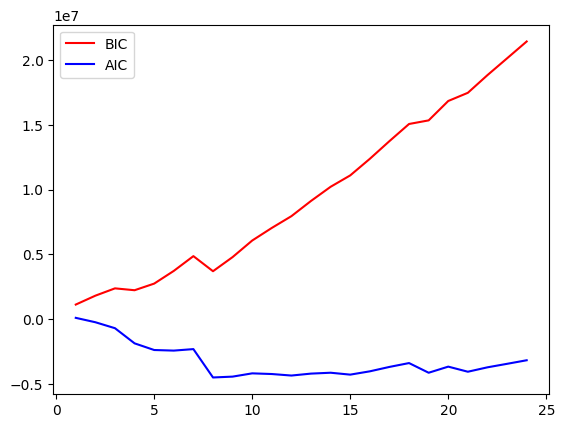

In [34]:
GMMs_na = find_nb_cluster(opt_cluster_data_na, 25)

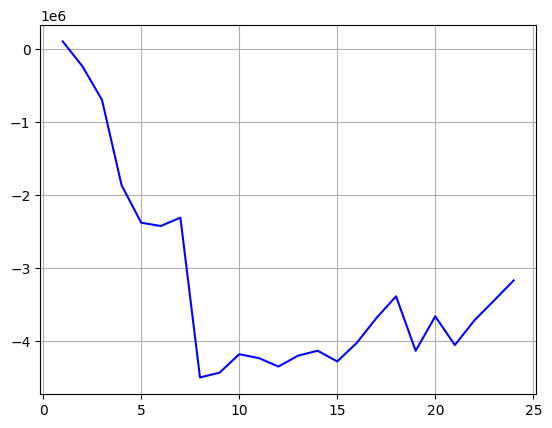

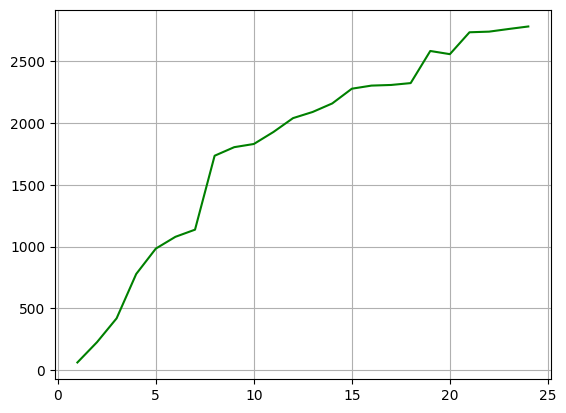

In [35]:
find_nb_cluster_2(GMMs_na, opt_cluster_data_na)

Using the plots above we will take a number of components equal to $(16+16)/2 = 16$.

In [36]:
opt_cluster_label_na = np.array([1 for i in range(len(transformed1_na))] + [0 for i in range(len(transformed2_na))])

In [37]:
liste_na = evaluate_cluster_purity(GMMs_na[15], opt_cluster_data_na, opt_cluster_label_na)

In [38]:
print("Functional label ratio = " + str(int(sum(opt_cluster_label_na)/len(opt_cluster_label_na)*100)) + " % \n")

for element in liste_na:
  print(f"Cluster {element['cluster']+1} : functional ratio = {int(element['functional_ratio']*100)} %")

Functional label ratio = 52 % 

Cluster 1 : functional ratio = 18 %
Cluster 2 : functional ratio = 46 %
Cluster 3 : functional ratio = 50 %
Cluster 4 : functional ratio = 53 %
Cluster 5 : functional ratio = 44 %
Cluster 6 : functional ratio = 12 %
Cluster 7 : functional ratio = 28 %
Cluster 8 : functional ratio = 65 %
Cluster 9 : functional ratio = 60 %
Cluster 10 : functional ratio = 89 %
Cluster 11 : functional ratio = 65 %
Cluster 12 : functional ratio = 43 %
Cluster 13 : functional ratio = 43 %
Cluster 14 : functional ratio = 23 %
Cluster 15 : functional ratio = 68 %
Cluster 16 : functional ratio = 84 %


In [39]:
print("Functional label ratio = " + str(int(sum(opt_cluster_label_na)/len(opt_cluster_label_na)*100)) + " % \n")

for element in liste_na:
  print(f"Cluster {element['cluster']+1} : size = {element['size']}")

Functional label ratio = 52 % 

Cluster 1 : size = 122
Cluster 2 : size = 110
Cluster 3 : size = 158
Cluster 4 : size = 69
Cluster 5 : size = 106
Cluster 6 : size = 80
Cluster 7 : size = 71
Cluster 8 : size = 517
Cluster 9 : size = 120
Cluster 10 : size = 67
Cluster 11 : size = 219
Cluster 12 : size = 104
Cluster 13 : size = 121
Cluster 14 : size = 86
Cluster 15 : size = 151
Cluster 16 : size = 32


From the functional ratios above we see that the two datasets are not well separated by the procedure. Indeed, the functional ratio takes values between 14% and 89%, the natural and artificial sequences are mixed in natural and artificial sequences.

# Task 4

In order to test the classifiers we did cross validation with a train dataset containing 70% of the data and a validation and test dataset with 15% both.

We considered functional_false = 0 and functional_true = 1

In [40]:
# Prepare feature matrix (X) and label vector (y) from encoded data
def prepare_X_y(encoded_data, raw_data):
    X = np.array(list(encoded_data.values()))  # Feature matrix (encoded sequences)
    y = np.array([1 if values["Functional_Label"] == "functional_true" else 0
                  for values in raw_data.values()])  # Labels: 1 for functional, 0 for non-functional
    return X, y

# Natural dataset
X_natural, y_natural = prepare_X_y(encoded_natural, natural)

# Artificial dataset
X_artificial, y_artificial = prepare_X_y(encoded_artificial, artificial)


In [41]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_natural, y_natural, test_size=0.3, random_state=1)

# Further split the temporary set into test (15%) and validation (15%) sets
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Split artificial data
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_artificial, y_artificial, test_size=0.3, random_state=1)
X_test_a, X_valid_a, y_test_a, y_valid_a = train_test_split(X_test_a, y_test_a, test_size=0.5, random_state=1)

# Print the number of samples in each set
print("Number of training samples: ", X_train.shape[0])
print("Number of validation samples: ", X_valid.shape[0])
print("Number of test samples: ", X_test.shape[0])

Number of training samples:  791
Number of validation samples:  170
Number of test samples:  169


Let's train a model using the training data and examine the confusion matrix on the validation set.
The confusion matrix provides the counts of false negatives and false positives, giving us insight into the model's performance.

Confusion Matrix: 
 [[93  7]
 [27 43]]


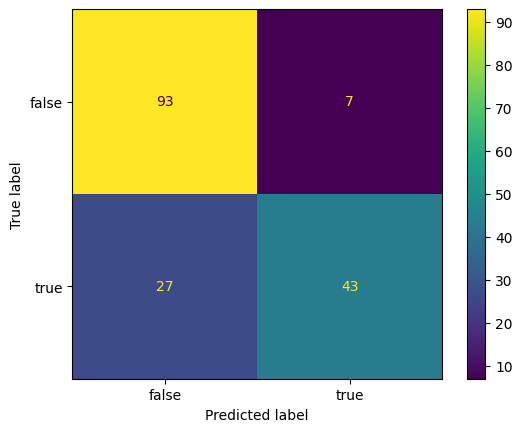

Class order in confusion matrix: [0 1]


In [42]:
# Initialize and fit the logistic regression model on the training data
model_c = LogisticRegression(C=0.05)
model_c.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model_c.predict(X_valid)

# Calculate prediction probabilities
prob = model_c.predict_proba(X_valid)

# Generate the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Print the confusion matrix
print("Confusion Matrix: \n", cm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['false', 'true'])
disp.plot()

# Update plot settings
plt.rcParams.update({'font.size': 12})
plt.grid(False)
plt.show()

print("Class order in confusion matrix:", model_c.classes_)


The default setup we used is a hard classifier, which assigns the class label based on the highest probability:

$P(True)>T$, being T the parameter (0.5 in the default logistic function)

For this case we achieved a good clasisfication for 89 % of the non funtional and 68 % of the functional.
However, depending on the goal, it can be more important to identify correclty the functional or non functional proteins.

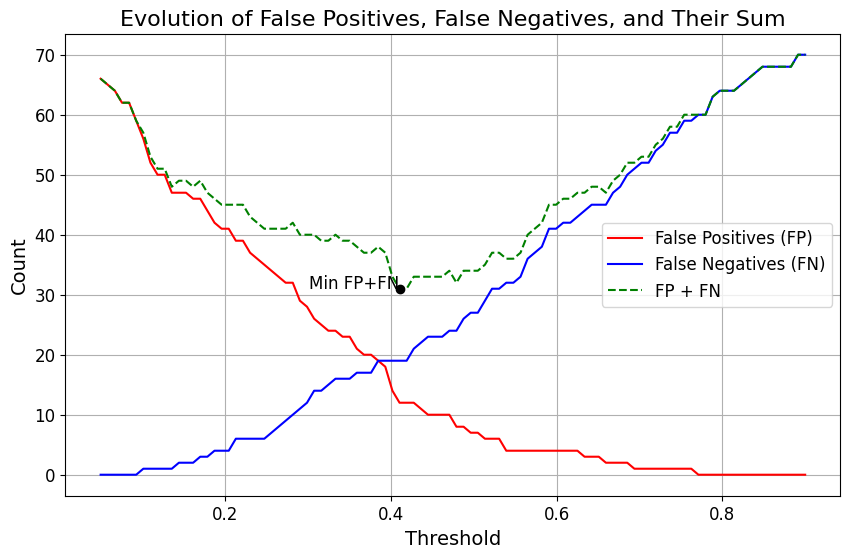

Optimal threshold: 0.4106060606060606
Minimum sum of FP and FN: 31


In [43]:
def find_optimal_threshold(prob, y_valid):
    # Define a range of thresholds
    thresholds = np.linspace(0.05, 0.9, 100)

    # Initialize arrays to store FP, FN, and their sum
    false_positives = []
    false_negatives = []
    fp_fn_sum = []

    # Iterate over thresholds and compute FP, FN, and their sum
    for thr in thresholds:
        # Apply the threshold to classify
        y_pred = np.where(prob[:, 1] >= thr, 1, 0)

        # Compute confusion matrix
        cm = confusion_matrix(y_valid, y_pred)
        fp = cm[0, 1]  # False Positives
        fn = cm[1, 0]  # False Negatives

        # Append results
        false_positives.append(fp)
        false_negatives.append(fn)
        fp_fn_sum.append(fp + fn)  # Sum of FP and FN

    # Find the minimum sum of FP and FN and the corresponding threshold
    min_index = np.argmin(fp_fn_sum)
    optimal_threshold = thresholds[min_index]
    min_fp_fn_sum = fp_fn_sum[min_index]

    # Plot FP, FN, and their sum as a function of the threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, false_positives, label="False Positives (FP)", color='red')
    plt.plot(thresholds, false_negatives, label="False Negatives (FN)", color='blue')
    plt.plot(thresholds, fp_fn_sum, label="FP + FN", color='green', linestyle='--')
    plt.scatter([optimal_threshold], [min_fp_fn_sum], color='black', zorder=5)
    plt.text(optimal_threshold, min_fp_fn_sum, f'Min FP+FN', fontsize=12, ha='right')
    plt.xlabel("Threshold", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Evolution of False Positives, False Negatives, and Their Sum", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    return optimal_threshold, min_fp_fn_sum

# Example usage (assuming 'prob' and 'y_valid' are defined)
optimal_threshold, min_fp_fn_sum = find_optimal_threshold(prob, y_valid)
print("Optimal threshold:", optimal_threshold)
print("Minimum sum of FP and FN:", min_fp_fn_sum)

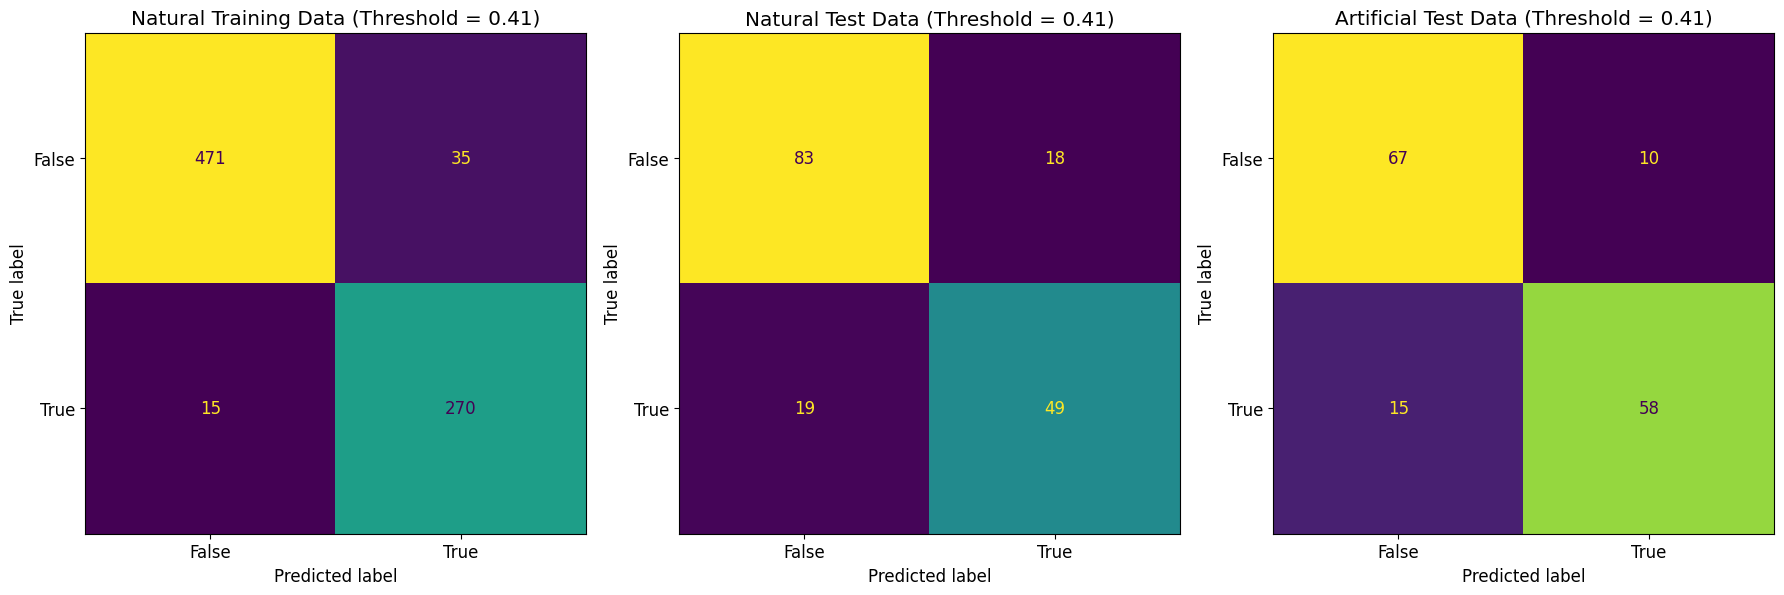

In [44]:
# Compute probabilities for the test set
prob_test = model_c.predict_proba(X_test)
prob_test_a = model_c.predict_proba(X_test_a)
prob_train = model_c.predict_proba(X_train)

# Custom threshold
custom_threshold = 0.41

# Predict for natural test data using the custom threshold
y_custom_pred_test_natural = np.where(prob_test[:, 1] >= custom_threshold, 1, 0)
custom_cm_test_natural = confusion_matrix(y_test, y_custom_pred_test_natural)

# Predict for artificial test data using the custom threshold
y_custom_pred_test_artificial = np.where(prob_test_a[:, 1] >= custom_threshold, 1, 0)
custom_cm_test_artificial = confusion_matrix(y_test_a, y_custom_pred_test_artificial)

# Confusion matrix for natural training data
y_custom_pred_train_natural = np.where(prob_train[:, 1] >= custom_threshold, 1, 0)
custom_cm_train_natural = confusion_matrix(y_train, y_custom_pred_train_natural)


# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for side-by-side comparison

# Natural Training Data Confusion Matrix
disp_train_natural = ConfusionMatrixDisplay(confusion_matrix=custom_cm_train_natural, display_labels=['False', 'True'])
disp_train_natural.plot(ax=axes[0], colorbar=False)
axes[0].set_title(f"Natural Training Data (Threshold = {custom_threshold:.2f})")
axes[0].grid(False)

# Natural Test Data Confusion Matrix
disp_test_natural = ConfusionMatrixDisplay(confusion_matrix=custom_cm_test_natural, display_labels=['False', 'True'])
disp_test_natural.plot(ax=axes[1], colorbar=False)
axes[1].set_title(f"Natural Test Data (Threshold = {custom_threshold:.2f})")
axes[1].grid(False)

# Artificial Test Data Confusion Matrix
disp_test_artificial = ConfusionMatrixDisplay(confusion_matrix=custom_cm_test_artificial, display_labels=['False', 'True'])
disp_test_artificial.plot(ax=axes[2], colorbar=False)
axes[2].set_title(f"Artificial Test Data (Threshold = {custom_threshold:.2f})")
axes[2].grid(False)

# Adjust spacing between plots
plt.subplots_adjust(wspace=0.4)

# Show plots
plt.tight_layout()
plt.show()

In [45]:
# Define a finer range of C values for stronger regularization
C_values = np.logspace(-4, 2, 20)  # Smaller values of C for stronger regularization

# Initialize lists to store RMSE
train_rmse = []
test_rmse = []

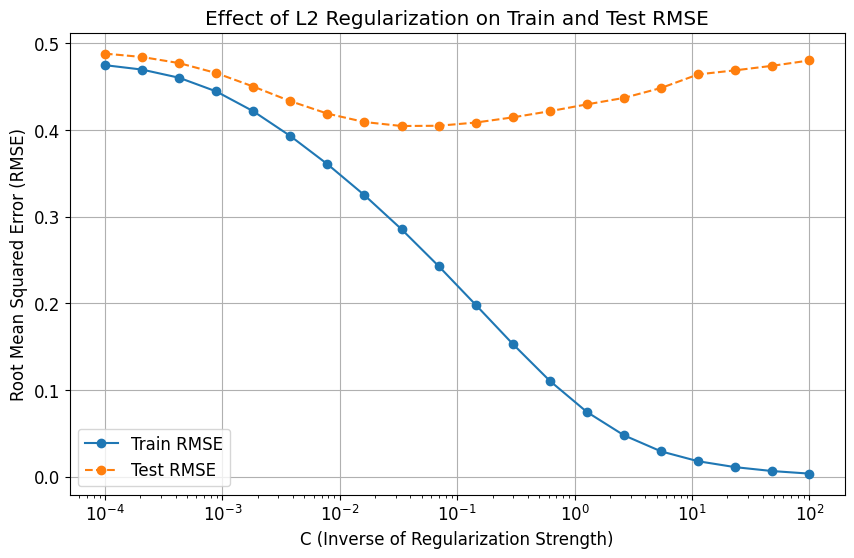

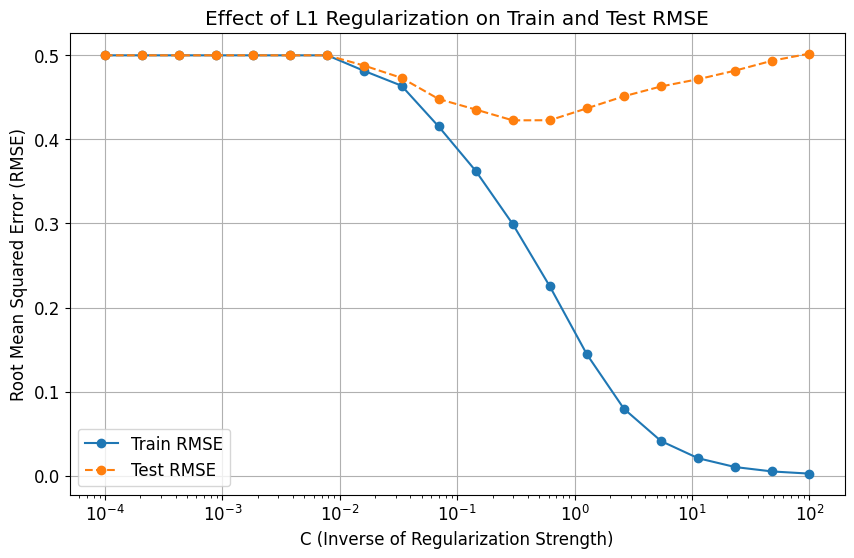

In [46]:
# Function to evaluate Logistic Regression model
def evaluate_logistic_regression(X_train, y_train, X_test, y_test, penalty=None, solver='lbfgs', C_values=None):
    train_rmse = []
    test_rmse = []

    C_values = np.logspace(-4, 2, 20)

    for C in C_values:
        # Train Logistic Regression model with the specified penalty
        model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predict probabilities for train and test sets
        y_train_prob = model.predict_proba(X_train)[:, 1]  # Predicted probabilities for class 1
        y_test_prob = model.predict_proba(X_test)[:, 1]

        # Compute RMSE
        train_rmse_value = np.sqrt(mean_squared_error(y_train, y_train_prob))
        test_rmse_value = np.sqrt(mean_squared_error(y_test, y_test_prob))

        train_rmse.append(train_rmse_value)
        test_rmse.append(test_rmse_value)

    return train_rmse, test_rmse

# Function to plot RMSE
def plot_rmse(C_values, train_rmse, test_rmse, title):
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, train_rmse, label="Train RMSE", marker='o', linestyle='-')
    plt.plot(C_values, test_rmse, label="Test RMSE", marker='o', linestyle='--')
    plt.xscale('log')  # Logarithmic scale for C values
    plt.xlabel("C (Inverse of Regularization Strength)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate models for Normal, L1, and L2 cases
results = {
    "L2 Regularization": evaluate_logistic_regression(X_train, y_train, X_test, y_test, penalty='l2', solver='lbfgs', C_values=C_values),
    "L1 Regularization": evaluate_logistic_regression(X_train, y_train, X_test, y_test, penalty='l1', solver='liblinear', C_values=C_values),
}

# Plot results for each case
for label, (train_rmse, test_rmse) in results.items():
    plot_rmse(C_values, train_rmse, test_rmse, f"Effect of {label} on Train and Test RMSE")


In [47]:
train_rmse, test_rmse = evaluate_logistic_regression(X_train, y_train, X_test, y_test, penalty='l2', solver='lbfgs', C_values=C_values)

# Find the best C based on minimum test RMSE
best_index = np.argmin(test_rmse)
best_C = C_values[best_index]
best_test_rmse = test_rmse[best_index]

# Print the results
print(f"Best C for L2 Regularization: {best_C}")
print(f"Test RMSE at Best C: {best_test_rmse:.4f}")

Best C for L2 Regularization: 0.03359818286283781
Test RMSE at Best C: 0.4047


To train our model choose C (inverse of the regularization strenght) equal to 0.034, in order to avoid overfitting.

At first glance, an RMSE of 0.4 might seem high for variables ranging from 0 to 1. However, the confusion matrix reveals that the model correctly classifies proteins with approximately 80% precision. This seemingly high RMSE can be attributed to the probabilities often being close to the 0.5 threshold. E.g. a protein with probability 0.6 to be functional is well classified, however, have a RMSE of 0.4.

# Task 5

In [48]:
def split_data(data): # Split into training and testing datasets
  X_train, X_test = train_test_split(data, test_size=0.3, random_state=1)

  # Further split the temporary set into test (15%) and validation (15%) sets
  X_test, X_valid = train_test_split(X_test, test_size=0.5, random_state=1)
  return X_train, X_test, X_valid

In [49]:
natural_ = np.vstack((True_natural, False_natural))


In [50]:
dico_VAE = {
    20: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     6: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     7: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     8: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    13: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    14: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    15: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    16: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    17: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    18: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    19: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
}

In [51]:
def letter2vector_VAE(a):
    switcher = {
        '-': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),  # Last position is 1 for "-"
        'A': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'C': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'D': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'E': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'F': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'G': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'H': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'I': np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'K': np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'L': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'M': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'N': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'P': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Q': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
        'R': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
        'S': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
        'T': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
        'V': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
        'W': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
        'Y': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    }
    return switcher.get(a, np.zeros(21))


def letter2number(a):
    switcher = {
        '-': 20,  # Last position is for "-"
        'A': 0,
        'C': 1,
        'D': 2,
        'E': 3,
        'F': 4,
        'G': 5,
        'H': 6,
        'I': 7,
        'K': 8,
        'L': 9,
        'M': 10,
        'N': 11,
        'P': 12,
        'Q': 13,
        'R': 14,
        'S': 15,
        'T': 16,
        'V': 17,
        'W': 18,
        'Y': 19,
    }
    return switcher.get(a, -1)  # Return -1 for unknown characters

In [52]:
def encode_sequence_VAE(sequence):
    return np.concatenate([letter2vector_VAE(letter) for letter in sequence])

def encode_sequence_VAE_to_number(sequence):
    return np.concatenate([letter2number(letter) for letter in sequence])

encoded_natural_VAE = {key: encode_sequence_VAE(value["Sequence"]) for key, value in natural.items()}
X_ohe = np.array(list(encoded_natural_VAE.values()))

encoded_natural_VAE_2 = {key: [letter2number(letter) for letter in value["Sequence"]] for key, value in natural.items()}
X_number = np.array(list(encoded_natural_VAE_2.values()))

In [53]:
################################ One-hot-encoding ########################################

# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, sequence_length, amino_acid_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(sequence_length * amino_acid_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(64, latent_dim)
        self.z_log_var = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, sequence_length * amino_acid_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std) # Samples random noise to introduce stochasticity in the latent space
        return z_mean + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Ensure input is flattened correctly (in the case of X_natural was already with the rigth shape)
        encoded = self.encoder(x)
        z_mean = self.z_mean(encoded)
        z_log_var = self.z_log_var(encoded)
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), sequence_length, amino_acid_dim), z_mean, z_log_var

# Define the loss function
def vae_loss_function(reconstructed, original, z_mean, z_log_var):
    # Ensure original and reconstructed tensors are flattened consistently
    original = original.view(reconstructed.size())  # Match sizes
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, original)  # Binary cross-entropy loss
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())  # KL divergence of two gaussian distributions (latent)
    return reconstruction_loss + kl_divergence  # Combine losses


def generate_sequences(num_sequences):
    """
    Generates sequences while allowing positions to be entirely 0 if all probabilities are below the threshold.
    If a number other than -1 is followed by -1 in the first 5 elements of a generated protein, it is changed to -1.
    """
    vae.eval()
    with torch.no_grad():
        latent_samples = torch.randn(num_sequences, latent_dim)  # Sample random latent vectors
        generated = vae.decoder(latent_samples).view(-1, sequence_length, amino_acid_dim)  # Decode latent vectors

        # Convert probabilities to numeric class indices
        generated_indices = torch.argmax(generated, dim=-1)

        generated_indices = np.array(generated_indices)

        hot_encoded_vectors = []
        for sequence in generated_indices:
          hot_encoded_vector = []
          for element in sequence:
            hot_encoded_vector += dico_VAE[element]
          hot_encoded_vectors.append(hot_encoded_vector)

    return  np.array(hot_encoded_vectors)



In [73]:
# Define constants
sequence_length = 96  # Number of positions in each sequence
amino_acid_dim = 21  # One-hot encoded dimension for each amino acid
latent_dim = 10  # Latent space dimension
batch_size = 30  # Number of sequences in each batch
epochs = 60  # Number of training iterations
validation_split = 0.2  # Fraction of the dataset used for validation

# Load your data (X_natural should be one-hot encoded and normalized)
# Example: X_natural = np.load("path_to_X_natural.npy")
X_tensor = torch.tensor(X_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor)

# Split dataset into training and validation sets
train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
vae = VAE(sequence_length, amino_acid_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training and validation loop
for epoch in range(epochs):
    # Training phase
    vae.train()
    total_train_loss = 0
    for batch in dataloader_train:
        inputs = batch[0]
        inputs = inputs.view(inputs.size(0), sequence_length, amino_acid_dim)  # Ensure correct shape
        inputs.requires_grad = True  # Ensure gradients are tracked
        optimizer.zero_grad()
        reconstructed, z_mean, z_log_var = vae(inputs)
        loss = vae_loss_function(reconstructed, inputs, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    vae.eval() # Uses learned statistics (from training) instead of calculating new ones.
    total_val_loss = 0
    with torch.no_grad(): # perform inference without gradient calculation, ensuring that validation data dosent leak into the model training
        for batch in dataloader_val:
            inputs = batch[0]
            inputs = inputs.view(inputs.size(0), sequence_length, amino_acid_dim)  # Ensure correct shape
            reconstructed, z_mean, z_log_var = vae(inputs)
            loss = vae_loss_function(reconstructed, inputs, z_mean, z_log_var)
            total_val_loss += loss.item()

    # Print epoch results
    avg_train_loss = total_train_loss / len(dataloader_train.dataset)
    avg_val_loss = total_val_loss / len(dataloader_val.dataset)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/60, Train Loss: 822.6432, Val Loss: 327.6360
Epoch 2/60, Train Loss: 314.3366, Val Loss: 301.5835
Epoch 3/60, Train Loss: 298.1013, Val Loss: 295.6878
Epoch 4/60, Train Loss: 293.9460, Val Loss: 293.3283
Epoch 5/60, Train Loss: 291.8079, Val Loss: 291.5183
Epoch 6/60, Train Loss: 289.8300, Val Loss: 289.7528
Epoch 7/60, Train Loss: 288.2981, Val Loss: 288.2456
Epoch 8/60, Train Loss: 287.4639, Val Loss: 287.6866
Epoch 9/60, Train Loss: 286.6721, Val Loss: 287.1394
Epoch 10/60, Train Loss: 285.8663, Val Loss: 287.4339
Epoch 11/60, Train Loss: 284.8769, Val Loss: 285.0399
Epoch 12/60, Train Loss: 281.5451, Val Loss: 279.9346
Epoch 13/60, Train Loss: 276.9581, Val Loss: 277.1155
Epoch 14/60, Train Loss: 274.4382, Val Loss: 274.8814
Epoch 15/60, Train Loss: 272.6197, Val Loss: 273.7987
Epoch 16/60, Train Loss: 271.5472, Val Loss: 272.7072
Epoch 17/60, Train Loss: 269.9509, Val Loss: 271.4336
Epoch 18/60, Train Loss: 267.4322, Val Loss: 269.3275
Epoch 19/60, Train Loss: 264.5350, Va

In [65]:
artificial_seq = generate_sequences(1000)
transformed_generated = pca_nat.transform(artificial_seq)

<ipython-input-66-352d65357965>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,0].legend()
<ipython-input-66-352d65357965>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
<ipython-input-66-352d65357965>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,2].legend()
<ipython-input-66-352d65357965>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,0].legend()
<ipython-input-66-352d65357965>:46: UserWarning: No artists with labels found to put in lege

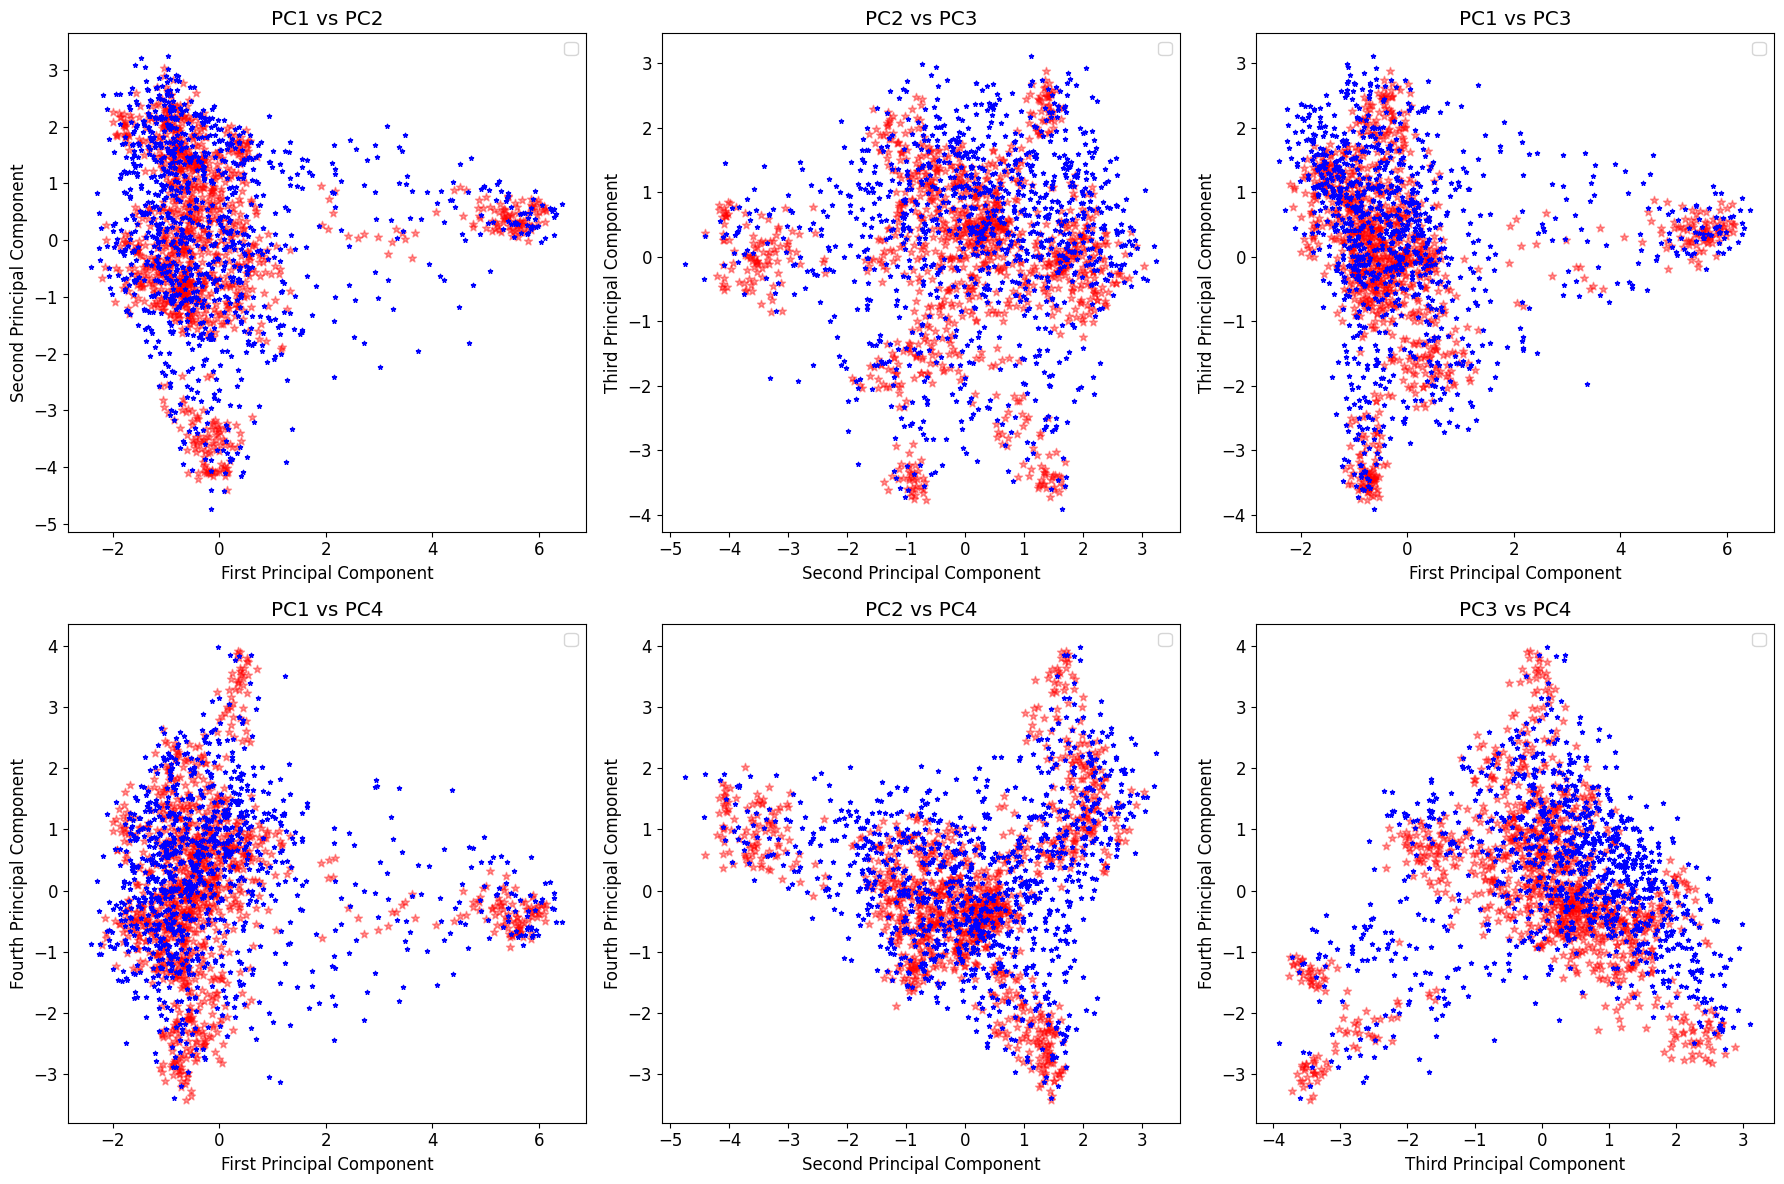

In [66]:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot PC1 vs PC2
    axes[0,0].scatter(transformed1[:, 0], transformed1[:, 1], alpha=opacity[0][0], color="r", marker="*")
    axes[0,0].scatter(transformed2[:, 0], transformed2[:, 1], alpha=opacity[0][1], color="r", marker="*")
    axes[0,0].scatter(transformed_generated[:, 0], transformed_generated[:, 1], color="b", marker="*", s=10)
    axes[0,0].set_xlabel('First Principal Component')
    axes[0,0].set_ylabel('Second Principal Component')
    axes[0,0].set_title('PC1 vs PC2')
    axes[0,0].legend()

    # Plot PC2 vs PC3
    axes[0,1].scatter(transformed1[:, 1], transformed1[:, 2], alpha=opacity[1][0], color="r", marker="*")
    axes[0,1].scatter(transformed2[:, 1], transformed2[:, 2], alpha=opacity[1][1], color="r", marker="*")
    axes[0,1].scatter(transformed_generated[:, 1], transformed_generated[:, 2], color="b", marker="*", s=10)
    axes[0,1].set_xlabel('Second Principal Component')
    axes[0,1].set_ylabel('Third Principal Component')
    axes[0,1].set_title('PC2 vs PC3')
    axes[0,1].legend()

    # Plot PC1 vs PC3
    axes[0,2].scatter(transformed1[:, 0], transformed1[:, 2], alpha=opacity[2][0], color="r", marker="*")
    axes[0,2].scatter(transformed2[:, 0], transformed2[:, 2], alpha=opacity[2][1], color="r", marker="*")
    axes[0,2].scatter(transformed_generated[:, 0], transformed_generated[:, 2], color="b", marker="*", s=10)
    axes[0,2].set_xlabel('First Principal Component')
    axes[0,2].set_ylabel('Third Principal Component')
    axes[0,2].set_title('PC1 vs PC3')
    axes[0,2].legend()

    # Plot PC1 vs PC4
    axes[1,0].scatter(transformed1[:, 0], transformed1[:, 3], alpha=opacity[3][0], color="r", marker="*")
    axes[1,0].scatter(transformed2[:, 0], transformed2[:, 3], alpha=opacity[3][1], color="r", marker="*")
    axes[1,0].scatter(transformed_generated[:, 0], transformed_generated[:, 3], color="b", marker="*", s=10)
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Fourth Principal Component')
    axes[1,0].set_title('PC1 vs PC4')
    axes[1,0].legend()

    # Plot PC2 vs PC4
    axes[1,1].scatter(transformed1[:, 1], transformed1[:, 3], alpha=opacity[4][0], color="r", marker="*")
    axes[1,1].scatter(transformed2[:, 1], transformed2[:, 3], alpha=opacity[4][1], color="r", marker="*")
    axes[1,1].scatter(transformed_generated[:, 1], transformed_generated[:, 3], color="b", marker="*", s=10)
    axes[1,1].set_xlabel('Second Principal Component')
    axes[1,1].set_ylabel('Fourth Principal Component')
    axes[1,1].set_title('PC2 vs PC4')
    axes[1,1].legend()

    # Plot PC3 vs PC4
    axes[1,2].scatter(transformed1[:, 2], transformed1[:, 3], alpha=opacity[5][0], color="r", marker="*")
    axes[1,2].scatter(transformed2[:, 2], transformed2[:, 3], alpha=opacity[5][1], color="r", marker="*")
    axes[1,2].scatter(transformed_generated[:, 2], transformed_generated[:, 3], color="b", marker="*", s=10)
    axes[1,2].set_xlabel('Third Principal Component')
    axes[1,2].set_ylabel('Fourth Principal Component')
    axes[1,2].set_title('PC3 vs PC4')
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

<ipython-input-67-d604c9f43504>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
<ipython-input-67-d604c9f43504>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


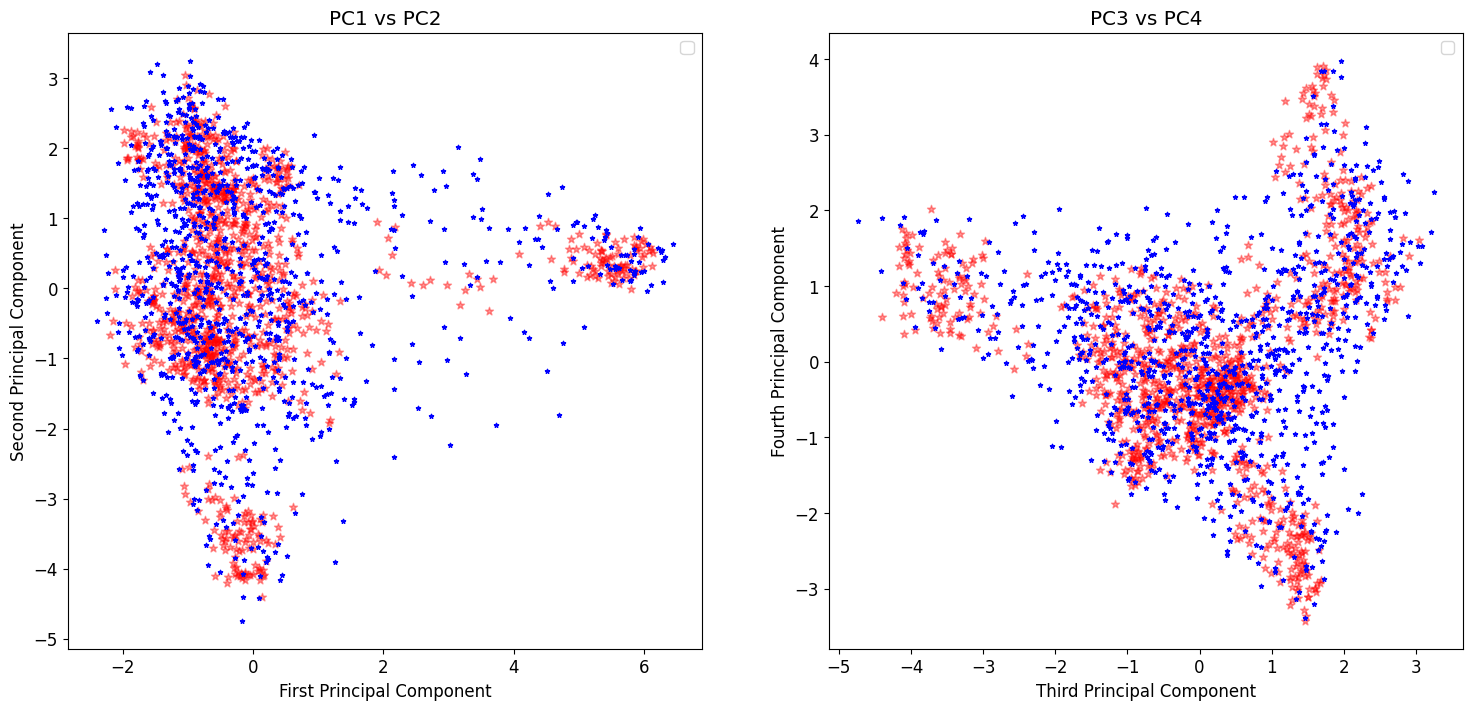

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot PC1 vs PC2
axes[0].scatter(transformed1[:, 0], transformed1[:, 1], alpha=opacity[0][0], color="r", marker="*")
axes[0].scatter(transformed2[:, 0], transformed2[:, 1], alpha=opacity[0][1], color="r", marker="*")
axes[0].scatter(transformed_generated[:, 0], transformed_generated[:, 1], color="b", marker="*", s=10)

axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PC1 vs PC2')
axes[0].legend()

# Plot PC3 vs PC4
axes[1].scatter(transformed1[:, 1], transformed1[:, 3], alpha=opacity[1][0], color="r", marker="*")
axes[1].scatter(transformed2[:, 1], transformed2[:, 3], alpha=opacity[1][1], color="r", marker="*")
axes[1].scatter(transformed_generated[:, 1], transformed_generated[:, 3], color="b", marker="*", s=10)
axes[1].set_xlabel('Third Principal Component')
axes[1].set_ylabel('Fourth Principal Component')
axes[1].set_title('PC3 vs PC4')
axes[1].legend()

In [68]:
artificial_trans_GMM = pca_natural.transform(artificial_seq)
labels_art = GMMs[11].predict(artificial_trans_GMM)
nb_data_point = [0 for i in range(12)]
for i in labels_art:
  nb_data_point[i-1] += 1

In [69]:
print(nb_data_point)

[79, 33, 18, 72, 28, 373, 33, 65, 134, 45, 16, 104]


In [70]:
for i, element in enumerate(nb_data_point):
  print(f"Number of points contained in Cluster {i+1} : {element} ")

Number of points contained in Cluster 1 : 79 
Number of points contained in Cluster 2 : 33 
Number of points contained in Cluster 3 : 18 
Number of points contained in Cluster 4 : 72 
Number of points contained in Cluster 5 : 28 
Number of points contained in Cluster 6 : 373 
Number of points contained in Cluster 7 : 33 
Number of points contained in Cluster 8 : 65 
Number of points contained in Cluster 9 : 134 
Number of points contained in Cluster 10 : 45 
Number of points contained in Cluster 11 : 16 
Number of points contained in Cluster 12 : 104 


In [71]:
nb_data_point_nat = []
for element in liste:
  nb_data_point_nat.append(element['size'])

In [72]:
for i in range(len(nb_data_point)):
  print(f"Relative difference in number of points contained in Cluster {i+1} : {abs((nb_data_point[i]-nb_data_point_nat[i])/nb_data_point[i]):.1f} ")

Relative difference in number of points contained in Cluster 1 : 0.9 
Relative difference in number of points contained in Cluster 2 : 2.0 
Relative difference in number of points contained in Cluster 3 : 1.9 
Relative difference in number of points contained in Cluster 4 : 0.4 
Relative difference in number of points contained in Cluster 5 : 2.8 
Relative difference in number of points contained in Cluster 6 : 0.9 
Relative difference in number of points contained in Cluster 7 : 5.2 
Relative difference in number of points contained in Cluster 8 : 0.1 
Relative difference in number of points contained in Cluster 9 : 0.2 
Relative difference in number of points contained in Cluster 10 : 2.1 
Relative difference in number of points contained in Cluster 11 : 4.2 
Relative difference in number of points contained in Cluster 12 : 0.6 


Thus it seems like our sequence generator is sampling from all clusters (we cannot be so sure about that since the datapoints could be very far from a cluster and still be associated to it since it is the closest). But it also seems like the proportions of points coming from different clusters are quite different between natural data and data that we generated (only four clusters have a relative difference smaller then 1).

In [63]:
# Grid search parameters
latent_dims = [10, 20, 30]
batch_sizes = [10, 20]
epochs_list = [50, 60]

# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, sequence_length, amino_acid_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(sequence_length * amino_acid_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(64, latent_dim)
        self.z_log_var = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, sequence_length * amino_acid_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std) # Samples random noise to introduce stochasticity in the latent space
        return z_mean + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Ensure input is flattened correctly (in the case of X_natural was already with the rigth shape)
        encoded = self.encoder(x)
        z_mean = self.z_mean(encoded)
        z_log_var = self.z_log_var(encoded)
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), sequence_length, amino_acid_dim), z_mean, z_log_var

# Define the loss function
def vae_loss_function(reconstructed, original, z_mean, z_log_var):
    # Ensure original and reconstructed tensors are flattened consistently
    original = original.view(reconstructed.size())  # Match sizes
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, original)  # Binary cross-entropy loss
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())  # KL divergence
    return reconstruction_loss + kl_divergence  # Combine losses

# Load your data (X_natural should be one-hot encoded and normalized)
# Example: X_natural = np.load("path_to_X_natural.npy")
X_tensor = torch.tensor(X_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor)

# Split dataset into training and validation sets
train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
vae = VAE(sequence_length, amino_acid_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Function to perform training and validation
def train_and_evaluate(latent_dim, batch_size, epochs):
    train_size = int((1 - 0.2) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    vae = VAE(sequence_length, amino_acid_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    vae.train()
    for epoch in range(epochs):
        for batch in dataloader_train:
            inputs = batch[0]
            optimizer.zero_grad()
            reconstructed, z_mean, z_log_var = vae(inputs)
            loss = vae_loss_function(reconstructed, inputs, z_mean, z_log_var)
            loss.backward()
            optimizer.step()

    vae.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in dataloader_val:
            inputs = batch[0]
            reconstructed, z_mean, z_log_var = vae(inputs)
            loss = vae_loss_function(reconstructed, inputs, z_mean, z_log_var)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader_val)
    return avg_val_loss

# Grid search
best_params = {}
min_loss = float('inf')

for latent_dim in latent_dims:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            val_loss = train_and_evaluate(latent_dim, batch_size, epochs)
            if val_loss < min_loss:
                min_loss = val_loss
                best_params = {'latent_dim': latent_dim, 'batch_size': batch_size, 'epochs': epochs}

print("Best parameters:", best_params)


Best parameters: {'latent_dim': 30, 'batch_size': 10, 'epochs': 60}
